In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-09-12 03:04:41.618325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load image data #####

data_path = "/root/data/data_HLfeature.h5"
data_file = h5py.File(data_path, 'r')
data_file.keys()

<KeysViewHDF5 ['H_0', 'H_1', 'J1_tau21', 'J2_tau21', 'LB_1', 'SS_0', 'SS_1', 'X_HH', 'deta_JJ', 'iht', 'm_J1', 'm_J2', 'm_JJ', 'target2', 'target3']>

In [3]:
##### include data #####

sig_len = 470063
ttbarBG_len = 548709
jjBG_len = 270777

print("signal length:", sig_len)
print("ttbarBG length:", ttbarBG_len)
print("jjBG length:", jjBG_len)

features_tradition = ['X_HH', 'iht', 'm_JJ', 'm_J1', 'm_J2', 'deta_JJ', 'J1_tau21', 'J2_tau21']
features_TDA = ['X_HH', 'iht', 'm_JJ', 'm_J1', 'm_J2', 'deta_JJ', 'J1_tau21', 'J2_tau21', 'H_0', 'H_1', 'SS_0', 'SS_1', 'LB_1']

data = []
for feature in features_TDA:
    data.append(data_file[feature][:])
data = np.array(data).T

target = data_file["target2"][:]

train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.2)

print("Shape of data:", np.shape(train_data))
print("Shape of target:", np.shape(train_target))

signal length: 470063
ttbarBG length: 548709
jjBG length: 270777
Shape of data: (1031639, 13)
Shape of target: (1031639,)


In [4]:
### build DNN model

DNN_TDA = Sequential()
DNN_TDA.add(keras.Input(shape=(13,)))
DNN_TDA.add(Dense(256, activation='relu'))
DNN_TDA.add(Dense(128, activation='relu'))
DNN_TDA.add(Dense(64, activation='relu'))
DNN_TDA.add(Dense(32, activation='relu'))
DNN_TDA.add(Dense(16, activation='relu'))
DNN_TDA.add(Dense(1, activation='sigmoid'))

### optimizer

opt = keras.optimizers.Adam(learning_rate=3e-4)

### compile

DNN_TDA.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","mse"])

### model shape

print(DNN_TDA.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 47361 (185.00 KB)
Trainable params: 47361 

2025-09-12 03:04:44.672166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44784 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-09-12 03:04:44.672920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46252 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [5]:
### train and save the model

tr_DNN = DNN_TDA.fit(train_data, train_target, validation_data=(val_data, val_target), batch_size=512, epochs=200, verbose=1)
DNN_TDA.save("/root/data/DNN_model_TDA_v1.h5")


Epoch 1/200


2025-09-12 03:04:46.906958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-09-12 03:04:46.910919: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbc83dedd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-12 03:04:46.910939: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-09-12 03:04:46.910944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-09-12 03:04:46.915790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-12 03:04:47.050555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-09-12 03:04:47.17664

2015/2015 [==============================] - 13s 5ms/step - loss: 0.6162 - accuracy: 0.6737 - mse: 0.2085 - val_loss: 0.5780 - val_accuracy: 0.6978 - val_mse: 0.1975
Epoch 2/200
2015/2015 [==============================] - 10s 5ms/step - loss: 0.5802 - accuracy: 0.6935 - mse: 0.1982 - val_loss: 0.5636 - val_accuracy: 0.7142 - val_mse: 0.1910
Epoch 3/200
2015/2015 [==============================] - 9s 5ms/step - loss: 0.5664 - accuracy: 0.7056 - mse: 0.1922 - val_loss: 0.5968 - val_accuracy: 0.6840 - val_mse: 0.2031
Epoch 4/200
2015/2015 [==============================] - 10s 5ms/step - loss: 0.5509 - accuracy: 0.7185 - mse: 0.1857 - val_loss: 0.5402 - val_accuracy: 0.7293 - val_mse: 0.1807
Epoch 5/200
2015/2015 [==============================] - 10s 5ms/step - loss: 0.5315 - accuracy: 0.7347 - mse: 0.1776 - val_loss: 0.5183 - val_accuracy: 0.7447 - val_mse: 0.1723
Epoch 6/200
2015/2015 [==============================] - 10s 5ms/step - loss: 0.5211 - accuracy: 0.7424 - mse: 0.1733 - val

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


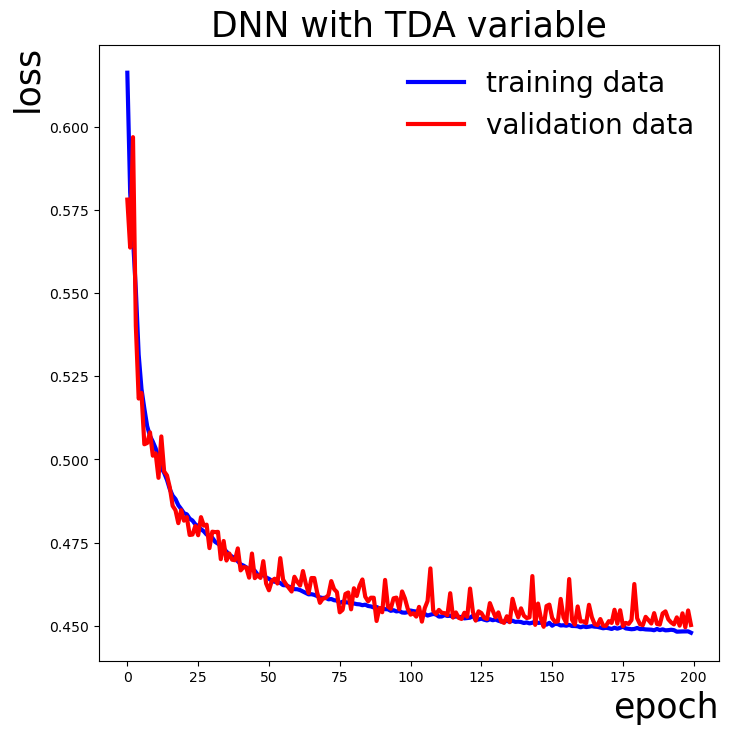

In [6]:
### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_DNN.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(tr_DNN.history["val_loss"], label='validation data',c='red',linewidth = 3)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

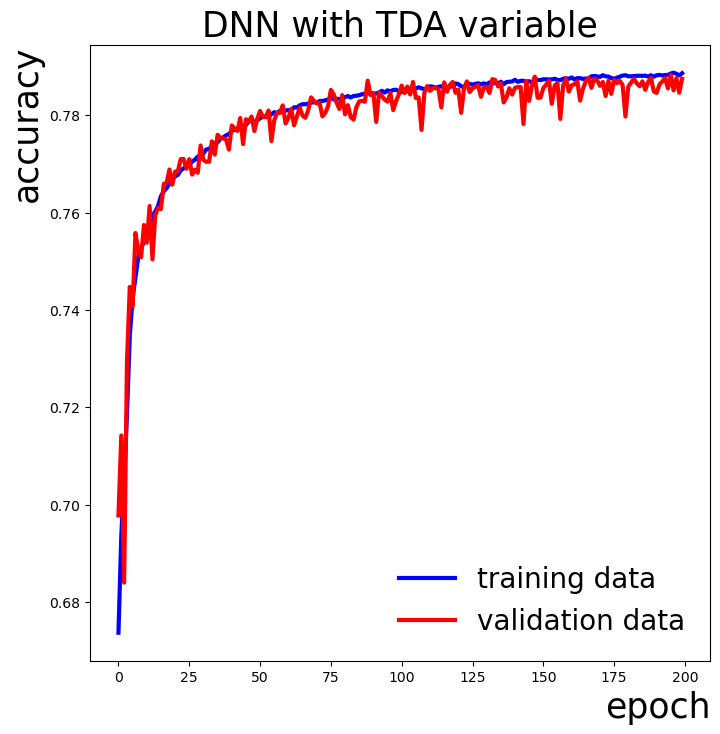

In [7]:
### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_DNN.history["accuracy"], label='training data',c='blue',linewidth = 3)
plt.plot(tr_DNN.history["val_accuracy"], label='validation data',c='red',linewidth = 3)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [8]:
print("Time:", time.time()-t1)

Time: 1927.1365389823914
